<a href="https://colab.research.google.com/github/linlih/ML_By_NTU_Hung-yi-Lee/blob/master/ml_2019spring_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## HW1作业说明

作业目标：给定9个小时豐原站的天气指标数据，预测的下一个小时的PM2.5值。

## 下载数据

Kaggle下载数据集的话需要进行身份验证，身份信息存储在kaggle.json文件中

kaggle.json文件需要在Kaggle官网的个人账号中进行生成。参考网址：https://www.kaggle.com/用户名/account ，其中用户名为你个人的用户名，这个页面在API的地方选择Create New API Token即可生成该文件。

注意：该文件只能有一个生效，生成多个，最后一个生成的才有效。

In [0]:
from google.colab import files
files.upload()

In [19]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [20]:
!kaggle competitions download -c ml2019spring-hw1

  0% 0.00/455k [00:00<?, ?B/s]
100% 455k/455k [00:00<00:00, 62.2MB/s]
  0% 0.00/192k [00:00<?, ?B/s]
100% 192k/192k [00:00<00:00, 61.5MB/s]
  0% 0.00/2.25k [00:00<?, ?B/s]
100% 2.25k/2.25k [00:00<00:00, 2.28MB/s]


In [21]:
!ls

kaggle.json  sample_data  sampleSubmission.csv	test.csv  train.csv


### 数据说明

从Kaggle上下载得到的数据中train.csv是存在编码错误的，使用Linux的命令iconv重新编码为UTF-8还是有问题，下载到本地，使用Notepad++打开并编码为UTF-8即可。

In [22]:
import pandas

# data = pandas.read_csv('train.csv', encoding='utf-8') 
# 这里的格式编码要注意修改成big5
data = pandas.read_csv('train.csv', encoding='big5')
data.head()

,日期,測站,測項,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,2014/1/1,豐原,AMB_TEMP,14,14,14,13,12,12,12,12,15,17,20,22,22,22,22,22,21,19,17,16,15,15,15,15
1,2014/1/1,豐原,CH4,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
2,2014/1/1,豐原,CO,0.51,0.41,0.39,0.37,0.35,0.3,0.37,0.47,0.78,0.74,0.59,0.52,0.41,0.4,0.37,0.37,0.47,0.69,0.56,0.45,0.38,0.35,0.36,0.32
3,2014/1/1,豐原,NMHC,0.2,0.15,0.13,0.12,0.11,0.06,0.1,0.13,0.26,0.23,0.2,0.18,0.12,0.11,0.1,0.13,0.14,0.23,0.18,0.12,0.1,0.09,0.1,0.08
4,2014/1/1,豐原,NO,0.9,0.6,0.5,1.7,1.8,1.5,1.9,2.2,6.6,7.9,4.2,2.9,3.4,3,2.5,2.2,2.5,2.3,2.1,1.9,1.5,1.6,1.8,1.5


In [23]:
data.info() # 可以看到所有的数据格式都为non-null，后面要将其给定为float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 27 columns):
日期    4320 non-null object
測站    4320 non-null object
測項    4320 non-null object
0     4320 non-null object
1     4320 non-null object
2     4320 non-null object
3     4320 non-null object
4     4320 non-null object
5     4320 non-null object
6     4320 non-null object
7     4320 non-null object
8     4320 non-null object
9     4320 non-null object
10    4320 non-null object
11    4320 non-null object
12    4320 non-null object
13    4320 non-null object
14    4320 non-null object
15    4320 non-null object
16    4320 non-null object
17    4320 non-null object
18    4320 non-null object
19    4320 non-null object
20    4320 non-null object
21    4320 non-null object
22    4320 non-null object
23    4320 non-null object
dtypes: object(27)
memory usage: 911.3+ KB


## 数据预处理、

数据格式的讲解见：
https://www.bilibili.com/video/av10590361/?p=9

分割出数据中的特征和标签

训练数据中给了24个小时的数据，总共是12个月，每个月20天，每天测量的是18个空气指标，在这里我们只选用PM2.5的空气指标，用前9个小时的PM2.5的值来预测第10个小时的PM2.5值。根据这个构建训练数据。

每天24个小时，所以一天总共可以生成15（24 - 9）个example。总共是240天，所以一共的训练example量为3600（240 X 15）个。

In [0]:
import numpy as np
np.set_printoptions(suppress=True) # 去掉科学计数法显示方式

data_ = data.drop(['日期','測站', '測項'], axis=1)

x_train_list = []
y_train_list = []
data_ = data_.replace(['NR'], [0.0])
data_ = np.array(data_).astype(float)

# 按照上面的描述分割数据集
for i in range(0, 4320, 18): # 总共有12*20*18=4320个数据行，以18为步长
    for j in range(15): # 每天可以生成15个训练example
        example = data_[i:i+18, j:j+9] # example shape (18,9)，这里取出了所有18个测试指标
        label = data_[i+9, j+9] # PM2.5的数据
        x_train_list.append(example)
        y_train_list.append(label)
x_train_all = np.array(x_train_list)
y_train = np.array(y_train_list)       

In [0]:
x_train = []
for i in range(3600): # 共3600个examples
    x_train.append([])
    for j in range(9):
        x_train[i].append(x_train_all[i,9,j])
x_train = np.array(x_train)

In [27]:
print(x_train.shape)
print(y_train.shape)

(3600, 9)
(3600,)


## 训练模型

整个过程分成三步，把前面9个小时的PM2.5当做特征，构建最简单的函数：y=wx+b，然后训练得到w和b的值进行预测。

1. function set

$$
y=b+w_{0} x_{0}+w_{1} x_{1}+\ldots+w_{9} x_{9}
 $$

2. Loss function
 $$ 
L=\frac{1}{2*m} \Sigma\left(y-y_{\text {train}}\right)^{2}
 $$

3. Find best function : Compute Gradient
$$ 
b=b-\eta * \frac{\vartheta L}{\vartheta b}=b-\eta * \Sigma \frac{1}{m} *\left(y-y_{\text {train}}\right) \frac{\vartheta y}{\vartheta b}=b-\eta * \Sigma \frac{1}{m} *\left(y-y_{\text {train}}\right)
 $$
 $$ 
w_{i}=w_{i}-\eta * \frac{\vartheta L}{\vartheta w_{i}}=w_{i}-\eta * \Sigma \frac{1}{m}\left(y-y_{\text {train}}\right) * x_{i}
 $$
 
 其中m为样本数目

1. Gradient Descent实现

In [0]:
# Gradient Descent
def GD(x_train, y_train, iteration, lr):
    b = 0.0 # 偏置值初始化
    w = np.ones(9) # 权重初始化

    loss_store = []
    for j in range(iteration):
        w_grad_sum = 0.0
        b_grad_sum = 0.0
        loss = 0.0
        # 在所有数据上计算梯度，梯度计算时针对损失函数求导
        for i in range(y_train.shape[0]):
            y = b + np.dot(w, x_train[i])
            w_grad = -1.0/y_train.shape[0]*(y_train[i] - y)*x_train[i]
            b_grad = -1.0/y_train.shape[0]*(y_train[i] - y)
            
            w_grad_sum += w_grad
            b_grad_sum += b_grad
            
            error = y_train[i] - y
            loss += error**2
        w = w - lr*w_grad_sum
        b = b - lr*b_grad_sum
        loss = loss/y_train.shape[0]
        print("after {} epochs, the loss is: ".format(j),loss)
        loss_store.append(loss)

    return w, b, loss_store

In [0]:
w, b, loss_store = GD(x_train, y_train, 1000, 0.000001)

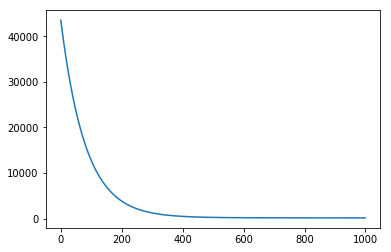

In [0]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_store)),loss_store)

2. Stochastic Gradient Descent 实现

In [0]:
# Stochastic Gradient Descent
def SGD(x_train, y_train, iteration, lr):
    b = 0.0 # 偏置值初始化
    w = np.ones(9) # 权重初始化

    loss_store = []
    
    for j in range(iteration):
        # 从数据集中随机选一个数据计算Gradient
        rand = np.random.randint(0, y_train.shape[0])
    
        y = b + np.dot(w, x_train[rand])
        w_grad = -1.0*(y_train[rand] - y)*x_train[rand]
        b_grad = -1.0*(y_train[rand] - y)

        error = y_train[rand] - y
        loss = error**2
        w = w - lr*w_grad
        b = b - lr*b_grad
        
        loss_store.append(loss)

    return w, b, loss_store

In [0]:
w, b, loss_store = SGD(train_x, train_y, 50000, 0.0000001)

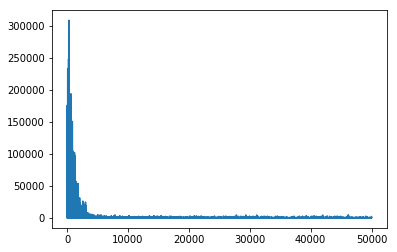

In [0]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_store)),loss_store)

3. Adagrad实现

In [0]:
def Adagrad(x_train, y_train, iteration, lr):
    b = 0.0 # 偏置值初始化
    w = np.ones(9) # 权重初始化
    b_lr = 0.0
    w_lr = 0.0

    loss_store = []
    for j in range(iteration):
        w_grad_sum = 0.0
        b_grad_sum = 0.0
        loss = 0.0
        # 在所有数据上计算梯度，梯度计算时针对损失函数求导
        for i in range(y_train.shape[0]):
            y = b + np.dot(w, x_train[i])
            w_grad = -1.0/y_train.shape[0]*(y_train[i] - y)*x_train[i]
            b_grad = -1.0/y_train.shape[0]*(y_train[i] - y)
            
            w_grad_sum += w_grad
            b_grad_sum += b_grad
       
            error = y_train[i] - y
            
            loss += error**2
        
        w_lr = w_lr + w_grad_sum**2
        b_lr = b_lr + b_grad_sum**2
        
        w = w - lr/np.sqrt(w_lr) * w_grad_sum
        b = b - lr/np.sqrt(b_lr) * b_grad_sum
        loss = loss/y_train.shape[0]/9
        print("after {} epochs, the loss is: ".format(j),loss)
        loss_store.append(loss)

    return w, b, loss_store

In [0]:
w, b, loss_store = Adagrad(x_train, y_train, 100, 0.1)
# 训练完的结果(10000, 0.1)： after 9999 epochs, the loss is:  5.13767154668965
# 训练完的结果(5000 , 0.5)： after 4999 epochs, the loss is:  4.795303444341576
# 训练完的结果(5000 , 1.0)： after 4999 epochs, the loss is:  4.794390440080361

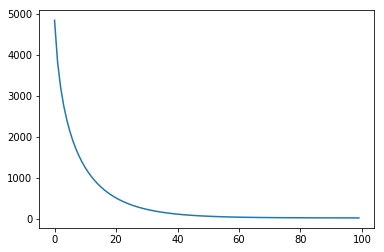

In [61]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_store)),loss_store)

## 测试数据

### 测试数据的处理

In [35]:
import pandas
test_data = pandas.read_csv('test.csv', encoding='utf-8', header=None)# 测试文件的第一行不是列属性
test_data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,id_0,AMB_TEMP,21,21,20,20,19,19,19,18,17
1,id_0,CH4,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.8
2,id_0,CO,0.39,0.36,0.36,0.4,0.53,0.55,0.34,0.31,0.23
3,id_0,NMHC,0.16,0.24,0.22,0.27,0.27,0.26,0.27,0.29,0.1
4,id_0,NO,1.3,1.3,1.3,1.3,1.4,1.6,1.2,1.1,0.9


In [0]:
test_data_ = test_data.drop([0, 1], axis=1)

test_data_ = test_data_.replace(['NR'], [0.0])
test_data_ = np.array(test_data_).astype(float)

test_data_x_list = []

# 按照上面的描述分割数据集
for i in range(0, 4320, 18): # 测试数据共有4320个数据行，以18为步长
    example = test_data_[i:i+18, 0:9] # example shape (18,9)
    test_data_x_list.append(example)

In [0]:
test_data_x_arr = np.array(test_data_x_list)

test_data_x = []
for i in range(240): # 总共240个测试数据
    test_data_x.append([])
    for j in range(9):
        test_data_x[i].append(test_data_x_arr[i,9,j])

In [0]:
np.array(test_data_x).shape

(240, 9)

In [0]:
# 包含小数部分的提交
predict = []
for i in range(240):
    y = b + np.dot(w,test_data_x[i])
    predict.append(y)

results = pd.Series(predict, name="value")
submission = pd.concat([pd.Series(["id_%d" % i for i in range(240)],name = "id"),results],axis = 1)
submission.to_csv('submission.csv', index=False)

In [0]:
# 去掉小数部分
res = []
for i in range(240):
    res.append(int(predict[i]))
res

results = pd.Series(res, name="value")
submission = pd.concat([pd.Series(["id_%d" % i for i in range(240)],name = "id"),results],axis = 1)
submission.to_csv('submission.csv', index=False)

In [43]:
submission.head()

,id,value
0,id_0,-0.920462
1,id_1,8.266412
2,id_2,19.734244
3,id_3,1.754795
4,id_4,21.480813


## 提交结果

使用Adagrad训练迭代10000次，学习率为0.1，训练得到的参数结果如下：

w: [ 0.0480092  -0.00509123  0.01689356 -0.02796585  0.04653025  0.13340423 -0.31917557  0.1099347   0.96548574]

b: 0.7212832358712717

提交到Kaggle的得到的分数为：6.50304，在private Leaderboard在13名左右。

如果去掉小数部分提交分数为：6.48652

----

使用Adagrad训练迭代5000次，学习率为0.5，训练得到的参数结果如下：

w: [ 0.00667528 -0.0367696   0.18275847 -0.19846756 -0.0345893   0.44443787
 -0.53391454  0.01922113  1.07311218]
 
b: 2.1087492095813527

提交到Kaggle的得到的分数为：5.95125，在private Leaderboard在6名左右。

去掉小数部分的分数为：5.98400

----

使用Adagrad训练迭代5000次，学习率为1.0，训练得到的参数结果如下：

w: [ 0.0071957  -0.04571828  0.19905271 -0.20752237 -0.04349567  0.46194178
 -0.54319042  0.0157119   1.07702657]
 
b: 2.152498260439194

提交到Kaggle的得到的分数为：5.93645，在private Leaderboard在6名左右。




In [57]:
!kaggle competitions submit ml2019spring-hw1 -f submission.csv -m "submit from colab"

100% 5.86k/5.86k [00:06<00:00, 995B/s]
Successfully submitted to ML2019spring-hw1

## 参考文章

完整这个作业过程中参考了以下zhexi文章，感谢这些同学的分享！

秋沐霖 : https://www.cnblogs.com/HL-space/p/10676637.html

丝瓜藤 : https://zhuanlan.zhihu.com/p/65400308

maplezzz : https://github.com/maplezzz/NTU_ML2017_Hung-yi-Lee_HW/tree/master/HW1
